# Hamburg Appartement Market Data Analysis and Modelling

<br>

### What factors impact the price the most?

<br>

#### 1. Which neighborhood has the highest impact?
#### 2. How do space and the number of rooms relate to the price?
#### 3. How do private offers impact the price?
#### 4. How do other factors impact the price?

### Importing packages

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

### Reading in the data

In [2]:
#the data comes from different excel files I scraped over a few months.
files = []
frames = []

for f in glob.glob(".\Data\*.xlsx"):
    files.append(f)
    frames.append(pd.read_excel(f, sheet_name="Sheet1"))

df = pd.concat(frames)

In [3]:
df.shape

(70620, 21)

In [4]:
df.head()

,ID,Haus/Wohnung,ID.1,Miete/Kauf,address,balcony,builtInKitchen,city,floorplan,from,...,lat,livingSpace,lon,numberOfRooms,postcode,price,privateOffer,quarter,title,url
0,107053440,Wohnung,107053440,Kauf,"Julius-Vosseler-Strasse 82a, Lokstedt, Hamburg",True,False,Hamburg,False,001.507379,...,53.59171,43.67,9.94497,2.0,22527,272937.5,False,Lokstedt,Eigentumswohnungen in Hamburg-Lokstedt,https://www.immobilienscout24.de/expose/107053440
1,109298032,Wohnung,109298032,Kauf,"Ohlsdorf, Hamburg",True,False,Hamburg,True,002.01004919249,...,NaN,117.00,NaN,4.0,22335,629800.0,False,Ohlsdorf,"629.800 €, 117 m², 4 Zimmer",https://www.immobilienscout24.de/expose/109298032
2,108673845,Wohnung,108673845,Kauf,"Alsterufer 10, Rotherbaum, Hamburg",False,False,Hamburg,False,001.5759162,...,53.56033,231.00,9.99611,5.0,20354,3520000.0,False,Rotherbaum,THE 10 - Luxury Flat mit Alsterblick für die F...,https://www.immobilienscout24.de/expose/108673845
3,108673576,Wohnung,108673576,Kauf,"Barmbek-Nord, Hamburg",True,True,Hamburg,True,001.5759162,...,NaN,97.00,NaN,3.0,22305,549000.0,False,Barmbek-Nord,Moderne 3-Zimmer-Wohnung mit Weitblick,https://www.immobilienscout24.de/expose/108673576
4,107298572,Wohnung,107298572,Kauf,"Grete-Zabe-Weg 13, Barmbek-Süd, Hamburg",True,False,Hamburg,True,001.177210,...,53.57751,64.43,10.05623,2.0,22081,398000.0,False,Barmbek-Süd,Citynah mit Blick ins Grüne: 2 Zimmer mit XL B...,https://www.immobilienscout24.de/expose/107298572


### Preprocessing the data

In [5]:
#I often sraped the data on censecutive days which results in duplicates
#I use the "ID" to identify the duplicates and drop them
dfu = df.drop_duplicates(subset="ID")

In [6]:
dfu.shape

(8625, 21)

In [7]:
#dropping columns I wont need.
dfu = dfu.drop(columns=["ID.1", "from", "title", "url", "Haus/Wohnung", "Miete/Kauf"])
dfu.head()

,ID,address,balcony,builtInKitchen,city,floorplan,garden,lat,livingSpace,lon,numberOfRooms,postcode,price,privateOffer,quarter
0,107053440,"Julius-Vosseler-Strasse 82a, Lokstedt, Hamburg",True,False,Hamburg,False,False,53.59171,43.67,9.94497,2.0,22527,272937.5,False,Lokstedt
1,109298032,"Ohlsdorf, Hamburg",True,False,Hamburg,True,True,NaN,117.00,NaN,4.0,22335,629800.0,False,Ohlsdorf
2,108673845,"Alsterufer 10, Rotherbaum, Hamburg",False,False,Hamburg,False,False,53.56033,231.00,9.99611,5.0,20354,3520000.0,False,Rotherbaum
3,108673576,"Barmbek-Nord, Hamburg",True,True,Hamburg,True,False,NaN,97.00,NaN,3.0,22305,549000.0,False,Barmbek-Nord
4,107298572,"Grete-Zabe-Weg 13, Barmbek-Süd, Hamburg",True,False,Hamburg,True,False,53.57751,64.43,10.05623,2.0,22081,398000.0,False,Barmbek-Süd


In [8]:
dfu = dfu.set_index("ID")

In [9]:
#looking for missing data
dfu.isnull().sum().sort_values(ascending=False)

lon               6243
lat               6243
quarter              0
privateOffer         0
price                0
postcode             0
numberOfRooms        0
livingSpace          0
garden               0
floorplan            0
city                 0
builtInKitchen       0
balcony              0
address              0
dtype: int64

In [10]:
#I will drop lon and lat because there are too many missing values
dfu = dfu.drop(columns=["lon", "lat"])

In [11]:
#since price is the value I want to predict I need to look for extreme values
dfu[dfu["price"] <= 10000]
#I should filter flats with a price of 0.
dfu = dfu[dfu["price"] != 0]

In [12]:
dfu.price

ID
107053440     272937.5
109298032     629800.0
108673845    3520000.0
108673576     549000.0
107298572     398000.0
               ...    
119053405     160000.0
118874098     179000.0
118939141     159000.0
118955621     279000.0
118919312     279000.0
Name: price, Length: 8618, dtype: float64

In [13]:
#For the modelling I need all bool field to be int.
boolcol = ['balcony', 'builtInKitchen', 'floorplan', 'garden', 'privateOffer']

for col in boolcol:
    dfu[col] = dfu[col].astype(int)

### Exploratory Analysis

In [14]:
#creating a function that plots the value counts per column

def plotchart(column):
    plt.figure(figsize=(10,5))
    ch = sns.countplot(dfu[column])
    ch.set_xticklabels(ch.get_xticklabels(), rotation=45, horizontalalignment='right')

In [15]:
#creating a list of the columns

columns = dfu.columns
columns

Index(['address', 'balcony', 'builtInKitchen', 'city', 'floorplan', 'garden',
       'livingSpace', 'numberOfRooms', 'postcode', 'price', 'privateOffer',
       'quarter'],
      dtype='object')

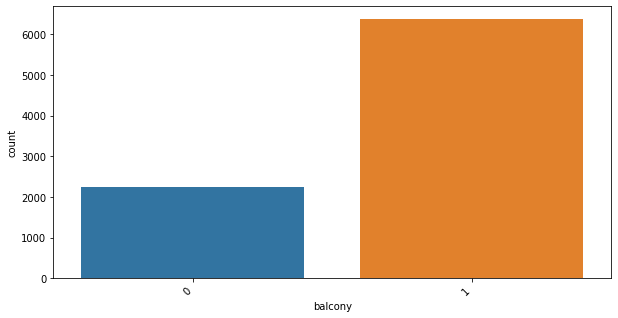

In [16]:
plotchart("balcony")

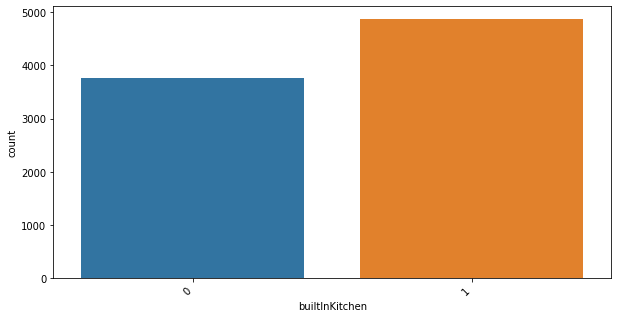

In [17]:
plotchart("builtInKitchen")

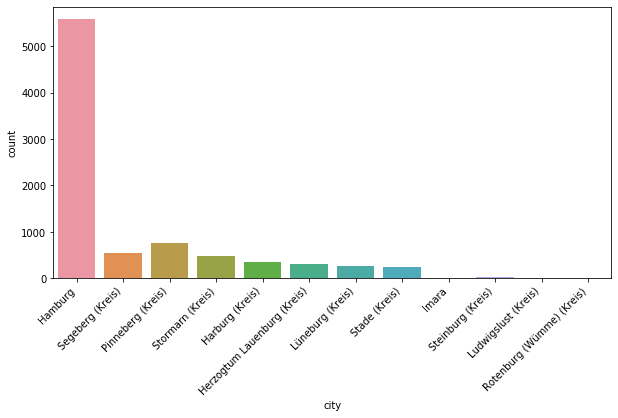

In [18]:
plotchart("city")

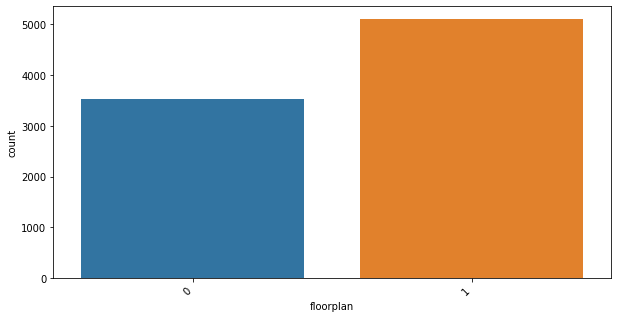

In [19]:
plotchart("floorplan")

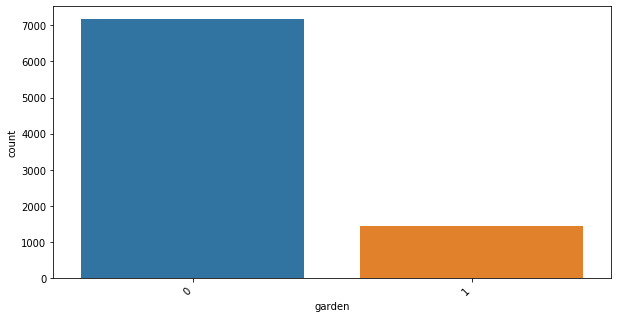

In [20]:
plotchart("garden")

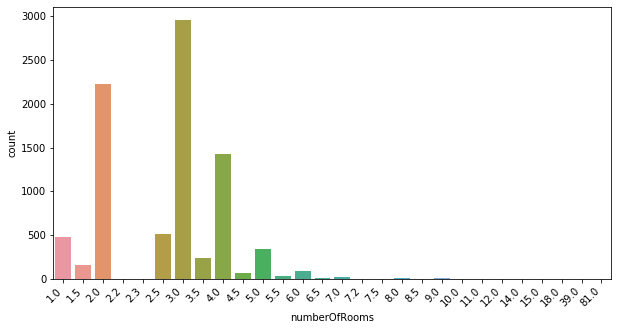

In [21]:
plotchart("numberOfRooms")

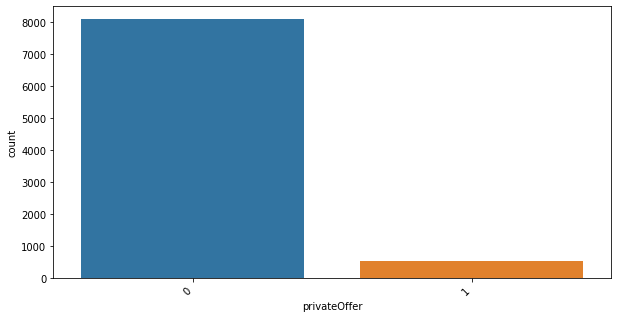

In [22]:
plotchart("privateOffer")

(array([7.972e+03, 4.630e+02, 1.170e+02, 4.100e+01, 1.500e+01, 5.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([7.0000e+03, 1.0163e+06, 2.0256e+06, 3.0349e+06, 4.0442e+06,
        5.0535e+06, 6.0628e+06, 7.0721e+06, 8.0814e+06, 9.0907e+06,
        1.0100e+07]),
 <a list of 10 Patch objects>)

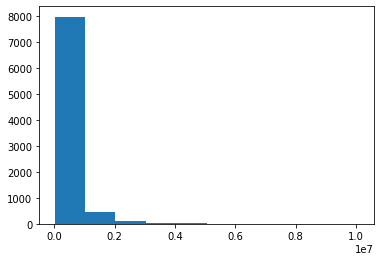

In [23]:
plt.hist(dfu["price"])

(array([8.351e+03, 2.540e+02, 1.100e+01, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <a list of 10 Patch objects>)

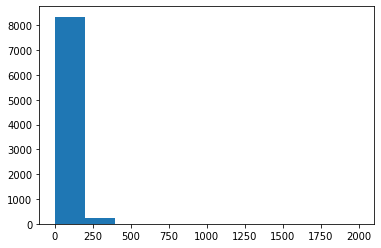

In [24]:
plt.hist(dfu["livingSpace"])

In [25]:
#creating a function that plots the sorted value counts per column for the top n elements

def plotcharttopn(column, n):
    
    plt.figure(figsize=(10,5))
    ch = sns.countplot(dfu[column], order=dfu[column].value_counts().iloc[:n].index)
    ch.set_xticklabels(ch.get_xticklabels(), rotation=45, horizontalalignment='right')

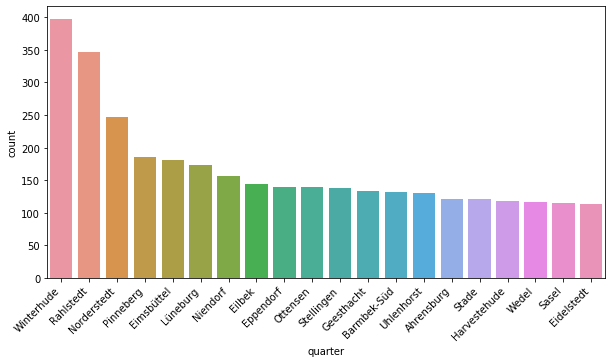

In [26]:
plotcharttopn("quarter", 20)

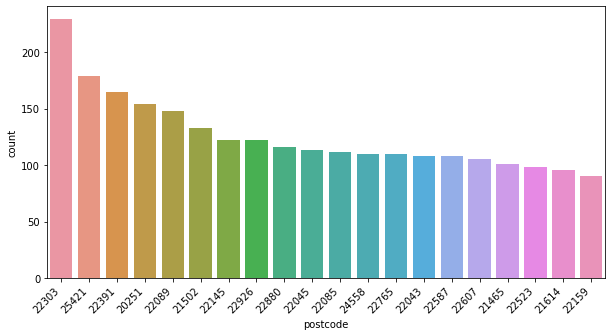

In [27]:
plotcharttopn("postcode", 20)

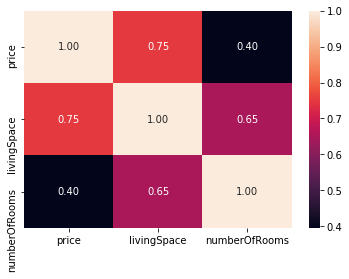

In [28]:
#checking numerical columns for correlation
sns.heatmap(dfu[["price", "livingSpace", "numberOfRooms"]].corr(), annot=True, fmt=".2f");

### Preparing data for medelling

In [29]:
#the postcode needs to be a string for one hot encoding
dfu["postcode"] = dfu["postcode"].astype(object)

In [30]:
cat_dfu = dfu[["postcode", "quarter", "city"]]

#One Hot Encoding the categorical columns
cat_dfu_dummies = pd.get_dummies(cat_dfu)
cat_dfu_dummies.head()

,postcode_19258,postcode_20087,postcode_20095,postcode_20097,postcode_20099,postcode_20144,postcode_20146,postcode_20148,postcode_20149,postcode_20249,...,city_Herzogtum Lauenburg (Kreis),city_Imara,city_Ludwigslust (Kreis),city_Lüneburg (Kreis),city_Pinneberg (Kreis),city_Rotenburg (Wümme) (Kreis),city_Segeberg (Kreis),city_Stade (Kreis),city_Steinburg (Kreis),city_Stormarn (Kreis)
ID,,,,,,,,,,,,,,,,,,,,,
107053440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109298032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108673845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108673576,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107298572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
num_dfu = dfu[["price", "livingSpace", "numberOfRooms"]]

In [32]:
bool_dfu = dfu[['balcony', 'builtInKitchen', 'floorplan', 'garden', 'privateOffer']]

In [33]:
#Combining the one hot encoded categorical columns with the numerical and bool columns.
dfu_mod = cat_dfu_dummies.join(num_dfu).join(bool_dfu)

In [34]:
dfu_mod.shape

(8618, 490)

### Modelling

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

#Split into explanatory and response variables
X = dfu_mod.drop(columns=['price'])
y = dfu_mod['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Instantiate model
ridge_model = Ridge()

#Get Model Parameters
ridge_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [36]:
#Instantiate parameters for GridSearchCV
parameters = {
    'alpha': [0.5, 1.0, 2.0],
    'solver': ['auto', 'svd'],
    'tol': [0.0005, 0.001, 0.002]
}

#Instantiate model
ridge_model = Ridge()

#GridSearc
cv = GridSearchCV(ridge_model, param_grid=parameters)

#Fit
cv.fit(X_train, y_train)

#Predict and score the model
y_test_preds_ridge = cv.predict(X_test)
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds_ridge), len(y_test))

'The r-squared score for the model was 0.7824320730798443 on 2586 values.'

In [37]:
cv.best_params_

{'alpha': 1.0, 'solver': 'auto', 'tol': 0.0005}

In [38]:
#Instantiate final model
model = Ridge(alpha=1.0,
 solver='auto',
 tol=0.0005)

#Fit
model.fit(X_train, y_train)

#Predict and score the model
y_test_preds_ridge = model.predict(X_test)
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds_ridge), len(y_test))

'The r-squared score for the model was 0.7824320730798443 on 2586 values.'

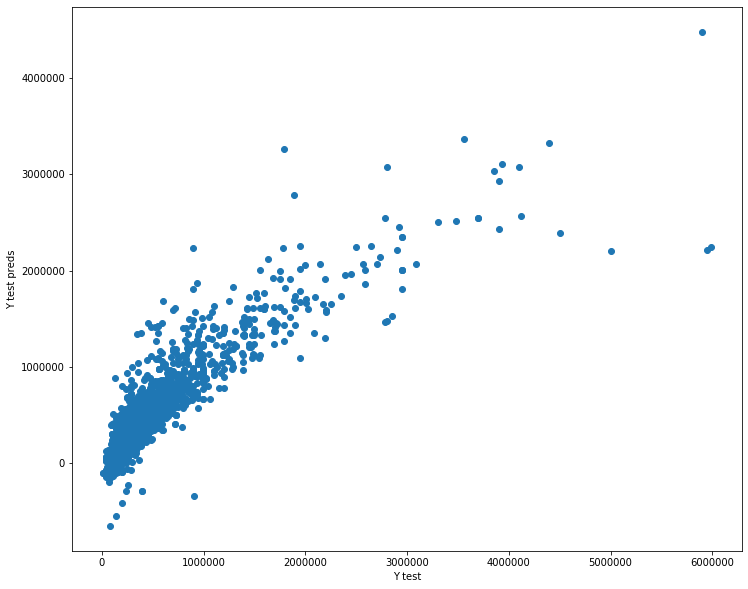

In [39]:
plt.figure(figsize=(12,10))
plt.scatter(y_test, y_test_preds_ridge)
plt.xlabel("Y test")
plt.ylabel("Y test preds")
plt.show()

### Checking the coefficients of the model

In [40]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['input_variable'] = X_train.columns
    coefs_df['coef'] = model.coef_
    coefs_df['abs_coef'] = np.abs(model.coef_)
    coefs_df = coefs_df.sort_values('abs_coef', ascending=False)
    return coefs_df

In [41]:
coef_df = coef_weights(model.coef_, X_train)

### 1. Which neighborhood has the highest impact?

In [42]:
coef_df[coef_df["input_variable"].str.startswith("postcode")].head(15)

,input_variable,coef,abs_coef
15,postcode_20354,960135.867895,960135.867895
24,postcode_20547,734660.071131,734660.071131
8,postcode_20149,518844.015906,518844.015906
7,postcode_20148,508216.953800,508216.953800
117,postcode_22301,392310.162057,392310.162057
5,postcode_20144,-369250.875223,369250.875223
116,postcode_22299,344105.152601,344105.152601
9,postcode_20249,344036.232804,344036.232804
33,postcode_21075,-303429.709292,303429.709292
4,postcode_20099,289664.179041,289664.179041


In [43]:
coef_df[coef_df["input_variable"].str.startswith("quarter")].head(15)

,input_variable,coef,abs_coef
312,quarter_HafenCity,760334.841146,760334.841146
326,quarter_Harvestehude,619668.882869,619668.882869
450,quarter_Uhlenhorst,541858.878035,541858.878035
330,quarter_Heimfeld,-440563.983210,440563.983210
380,quarter_Moorrege,-344568.688765,344568.688765
364,quarter_Langenbek,-263082.149974,263082.149974
335,quarter_Hoheluft-Ost,253468.021275,253468.021275
255,quarter_Barmbek-Nord,252848.216625,252848.216625
392,quarter_Nienstedten,239226.802933,239226.802933
424,quarter_Seeth-Ekholt,-232512.274076,232512.274076


In [44]:
coef_df[coef_df["input_variable"].str.startswith("city")].head(15)

,input_variable,coef,abs_coef
470,city_Hamburg,253269.663805,253269.663805
472,city_Herzogtum Lauenburg (Kreis),-76778.904779,76778.904779
480,city_Steinburg (Kreis),-52210.766504,52210.766504
478,city_Segeberg (Kreis),-42443.807201,42443.807201
481,city_Stormarn (Kreis),-35286.680322,35286.680322
475,city_Lüneburg (Kreis),-27593.281398,27593.281398
476,city_Pinneberg (Kreis),-18890.776257,18890.776257
479,city_Stade (Kreis),-11135.455833,11135.455833
474,city_Ludwigslust (Kreis),9845.848126,9845.848126
477,city_Rotenburg (Wümme) (Kreis),3007.806087,3007.806087


### 2. How do space and the number of rooms relate to the price?

In [45]:
coef_df[coef_df["input_variable"].str.startswith("livingSpace")]

,input_variable,coef,abs_coef
482,livingSpace,7560.726173,7560.726173


In [46]:
coef_df[coef_df["input_variable"].str.startswith("numberOfRooms")]

,input_variable,coef,abs_coef
483,numberOfRooms,-29043.204408,29043.204408


### 3. How do private offers impact the price?

In [47]:
coef_df[coef_df["input_variable"].str.startswith("privateOffer")]

,input_variable,coef,abs_coef
488,privateOffer,-1986.386911,1986.386911


### 4. How do other factors impact the price?

In [48]:
coef_df[coef_df["input_variable"].str.startswith("balcony")]

,input_variable,coef,abs_coef
484,balcony,19315.222434,19315.222434


In [49]:
coef_df[coef_df["input_variable"].str.startswith("builtInKitchen")]

,input_variable,coef,abs_coef
485,builtInKitchen,-21171.64429,21171.64429


In [50]:
coef_df[coef_df["input_variable"].str.startswith("floorplan")]

,input_variable,coef,abs_coef
486,floorplan,-8144.907764,8144.907764


In [51]:
coef_df[coef_df["input_variable"].str.startswith("garden")]

,input_variable,coef,abs_coef
487,garden,1991.212845,1991.212845
